#### Benchmaking Experiment 001
- Model : Model2
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
import math
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model9(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, dim_feedforward, ft_size, attr_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model9, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.attr_size = attr_size

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.Conv1dL = nn.Conv1d(self.max_len, 1, 1)
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1,0,2)
        out = self.Conv1dL(out).squeeze()
        out = self.DenseL2(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(out)
        ft_out = self.DecDenseL(attr_out)
        return attr_out, ft_out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 54.39batch/s, loss=3.81]


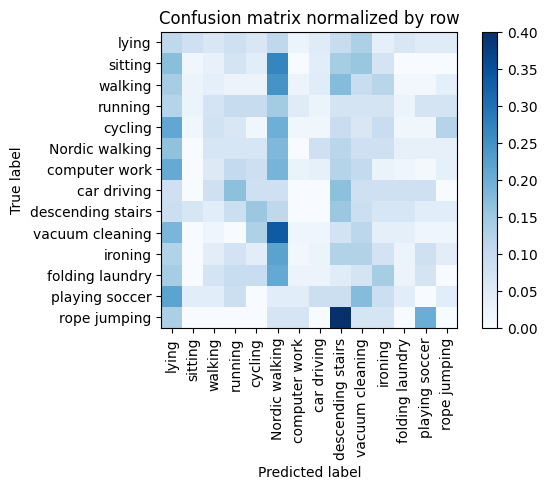

Training Epoch:  10%|█         | 1/10 [00:19<02:58, 19.87s/it]

Overall accuracy: 0.065



eval: 100%|██████████| 26/26 [00:00<00:00, 57.33batch/s, loss=2.33]


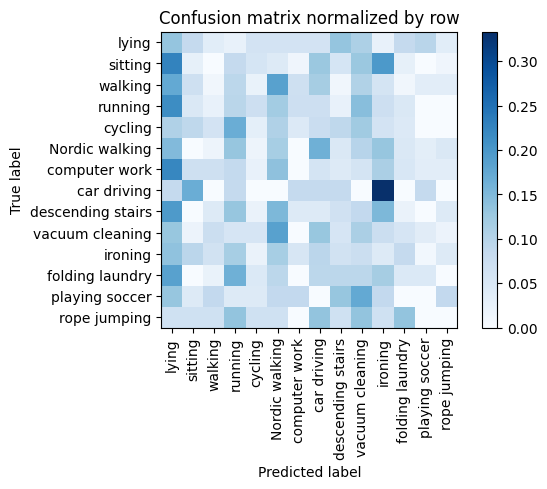

Training Epoch:  20%|██        | 2/10 [00:24<01:26, 10.82s/it]

Overall accuracy: 0.053



eval: 100%|██████████| 26/26 [00:00<00:00, 59.50batch/s, loss=1.56]


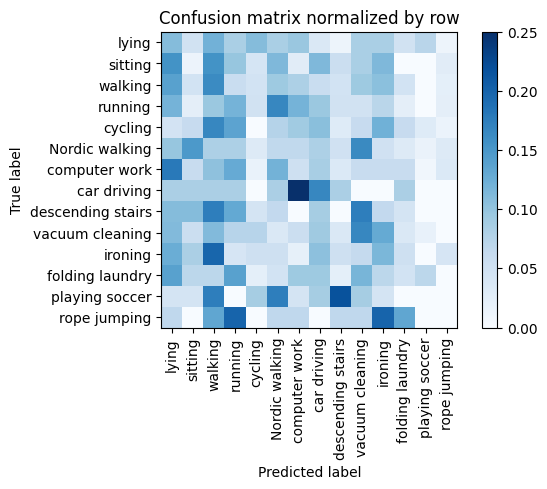

Training Epoch:  30%|███       | 3/10 [00:28<00:53,  7.65s/it]

Overall accuracy: 0.077



eval: 100%|██████████| 26/26 [00:00<00:00, 48.27batch/s, loss=1.05]


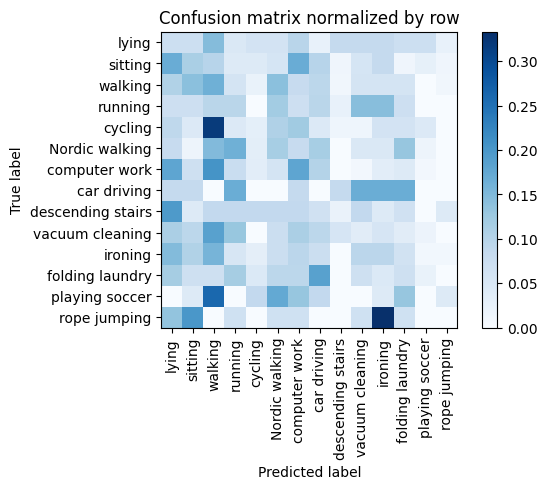

Training Epoch:  40%|████      | 4/10 [00:33<00:40,  6.69s/it]

Overall accuracy: 0.094



eval: 100%|██████████| 26/26 [00:00<00:00, 50.68batch/s, loss=0.82]


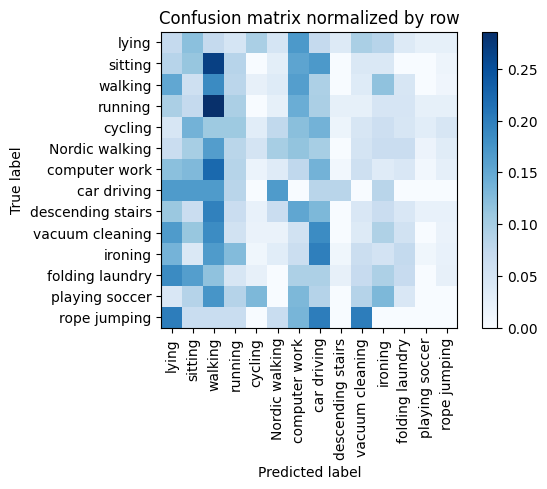

Training Epoch:  50%|█████     | 5/10 [00:38<00:31,  6.20s/it]

Overall accuracy: 0.076



eval: 100%|██████████| 26/26 [00:00<00:00, 54.97batch/s, loss=0.917]


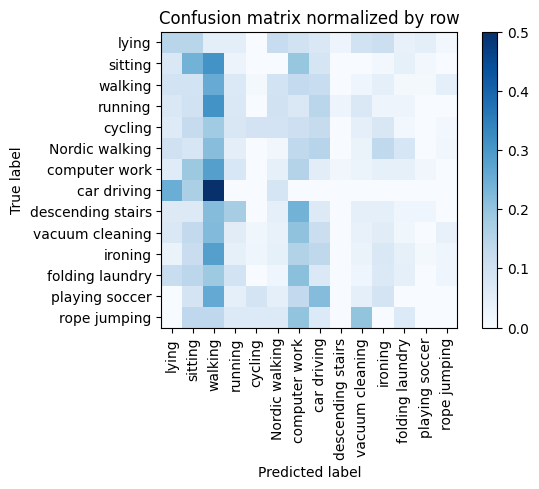

Training Epoch:  60%|██████    | 6/10 [00:44<00:23,  5.92s/it]

Overall accuracy: 0.110



eval: 100%|██████████| 26/26 [00:00<00:00, 47.97batch/s, loss=0.677]


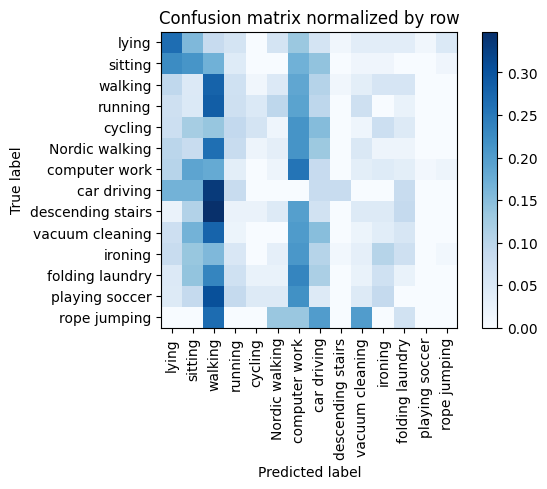

Training Epoch:  70%|███████   | 7/10 [00:49<00:17,  5.75s/it]

Overall accuracy: 0.139



eval: 100%|██████████| 26/26 [00:00<00:00, 48.82batch/s, loss=0.633]


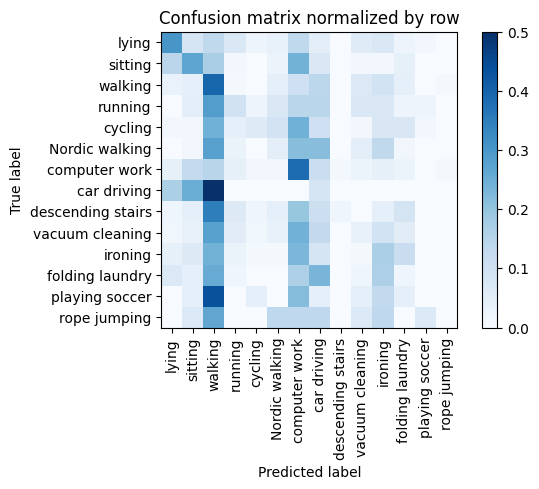

Training Epoch:  80%|████████  | 8/10 [00:54<00:11,  5.52s/it]

Overall accuracy: 0.190



eval: 100%|██████████| 26/26 [00:00<00:00, 57.65batch/s, loss=0.613]


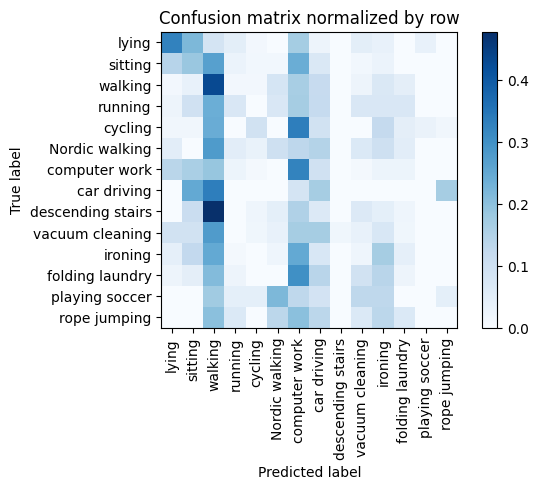

Training Epoch:  90%|█████████ | 9/10 [00:59<00:05,  5.36s/it]

Overall accuracy: 0.185



eval: 100%|██████████| 26/26 [00:00<00:00, 58.43batch/s, loss=0.527]


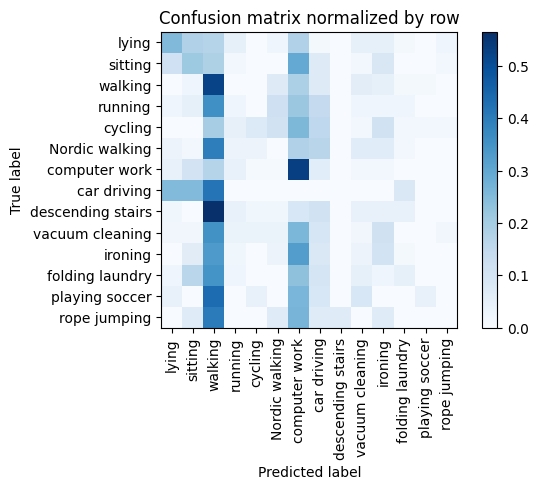

Overall accuracy: 0.200



eval: 100%|██████████| 28/28 [00:00<00:00, 74.27batch/s, loss=0.585]


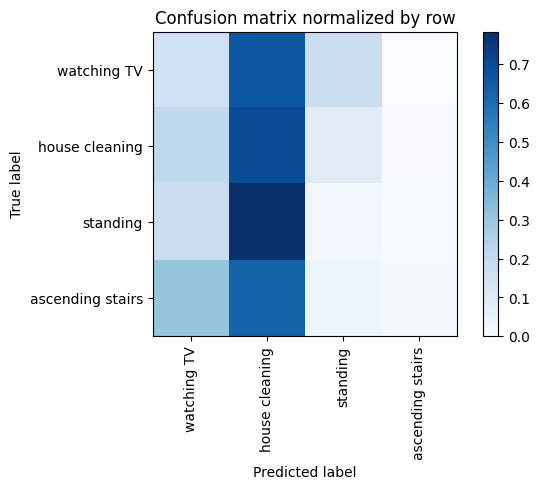

Overall accuracy: 0.255

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.131      0.027      0.045      0.338        296|	 house cleaning: 0.784,	watching TV: 0.179,	
  house cleaning       0.309      0.701      0.429      0.313        274|	 watching TV: 0.208,	standing: 0.088,	
ascending stairs       0.429      0.017      0.032      0.205        180|	 house cleaning: 0.633,	watching TV: 0.311,	standing: 0.039,	
     watching TV       0.108      0.159      0.128      0.144        126|	 house cleaning: 0.667,	standing: 0.175,	

----------------------------------------------------------------------------------------------------
     avg / total       0.244      0.255      0.174        1.0        876|	      

{'total_accuracy': 0.2545662100456621, 'precision': 0.2439818808252972, 'recall': 0.22578844485778796, 'f1': 0.15842001136118783}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping',

eval: 100%|██████████| 26/26 [00:00<00:00, 51.90batch/s, loss=4.55]


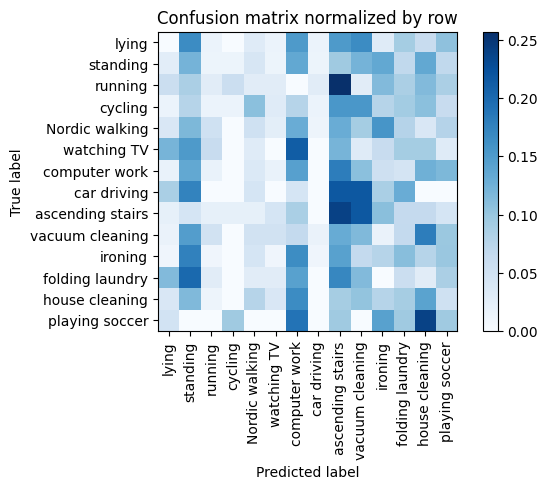

Training Epoch:  10%|█         | 1/10 [00:05<00:49,  5.48s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 26/26 [00:00<00:00, 49.52batch/s, loss=2.88]


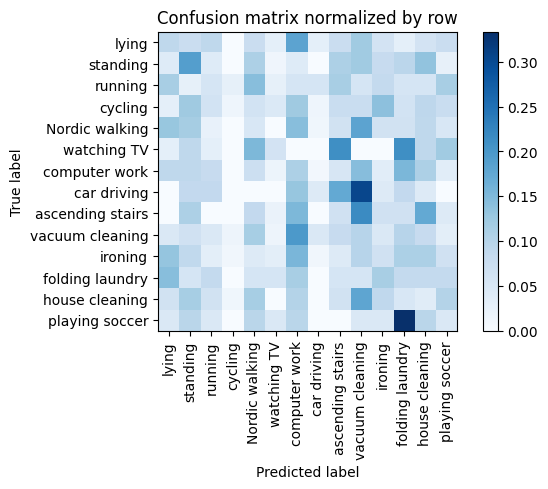

Training Epoch:  20%|██        | 2/10 [00:10<00:42,  5.34s/it]

Overall accuracy: 0.078



eval: 100%|██████████| 26/26 [00:00<00:00, 51.79batch/s, loss=2.08]


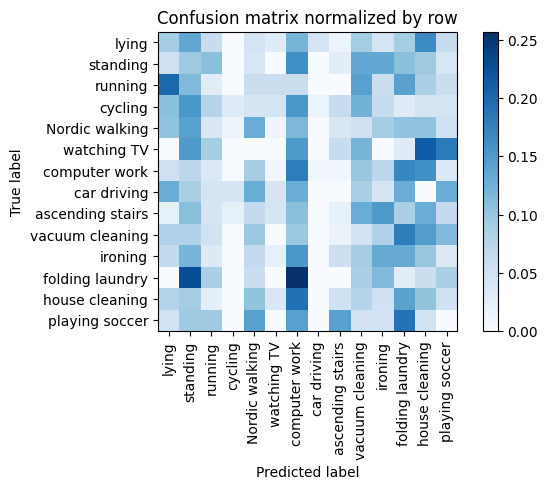

Training Epoch:  30%|███       | 3/10 [00:15<00:36,  5.21s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 26/26 [00:00<00:00, 47.23batch/s, loss=1.47]


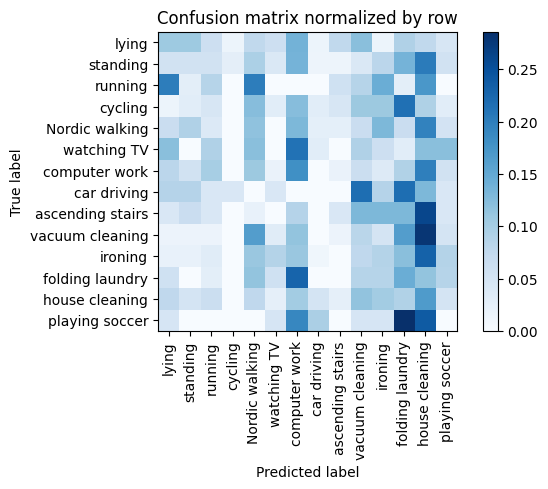

Training Epoch:  40%|████      | 4/10 [00:20<00:30,  5.16s/it]

Overall accuracy: 0.093



eval: 100%|██████████| 26/26 [00:00<00:00, 49.06batch/s, loss=1.07]


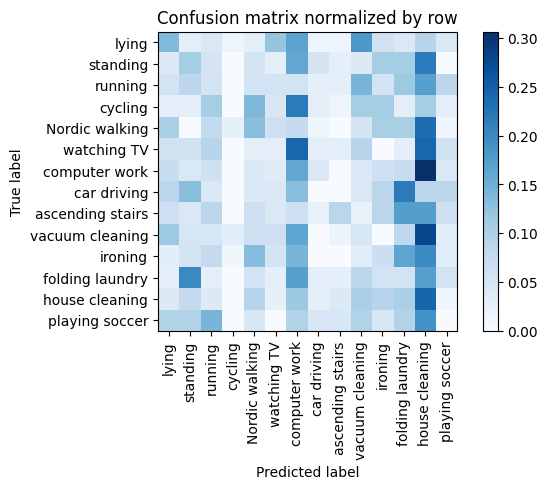

Training Epoch:  50%|█████     | 5/10 [00:26<00:26,  5.24s/it]

Overall accuracy: 0.100



eval: 100%|██████████| 26/26 [00:00<00:00, 53.39batch/s, loss=0.892]


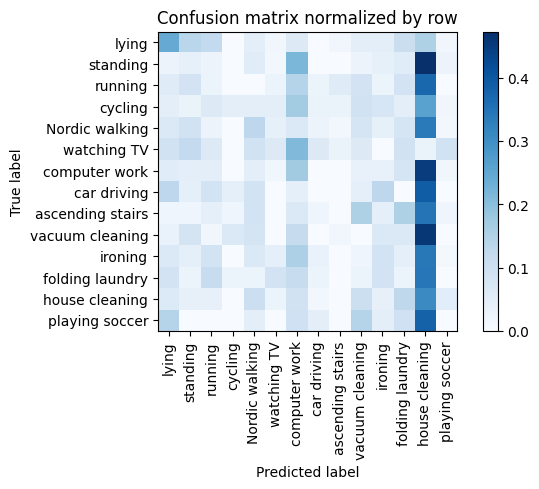

Training Epoch:  60%|██████    | 6/10 [00:31<00:20,  5.17s/it]

Overall accuracy: 0.107



eval: 100%|██████████| 26/26 [00:00<00:00, 53.28batch/s, loss=0.824]


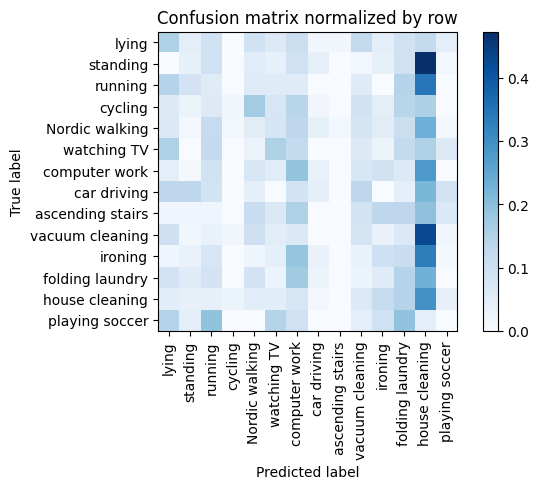

Training Epoch:  70%|███████   | 7/10 [00:36<00:15,  5.08s/it]

Overall accuracy: 0.109



eval: 100%|██████████| 26/26 [00:00<00:00, 52.74batch/s, loss=0.731]


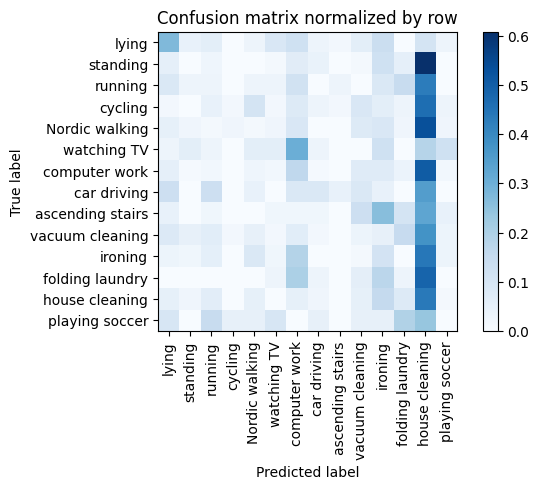

Training Epoch:  80%|████████  | 8/10 [00:41<00:10,  5.04s/it]

Overall accuracy: 0.110



eval: 100%|██████████| 26/26 [00:00<00:00, 53.28batch/s, loss=0.608]


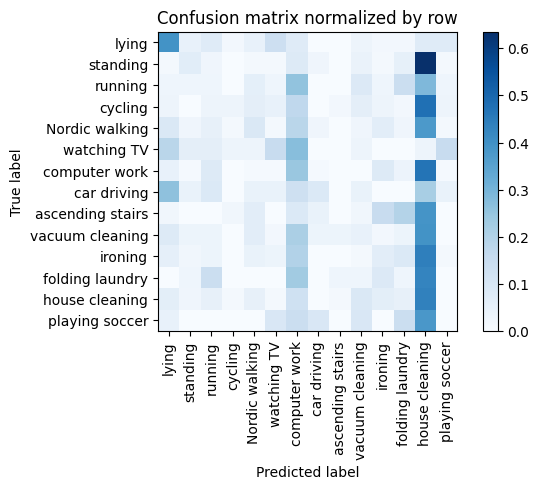

Training Epoch:  90%|█████████ | 9/10 [00:46<00:05,  5.05s/it]

Overall accuracy: 0.146



eval: 100%|██████████| 26/26 [00:00<00:00, 50.49batch/s, loss=0.602]


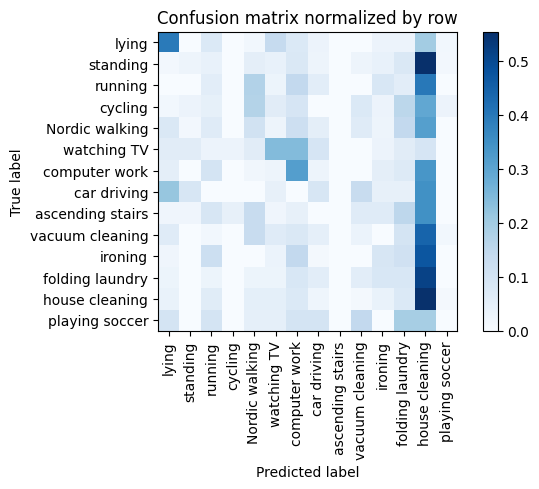

Overall accuracy: 0.170



eval: 100%|██████████| 28/28 [00:00<00:00, 67.27batch/s, loss=0.602]


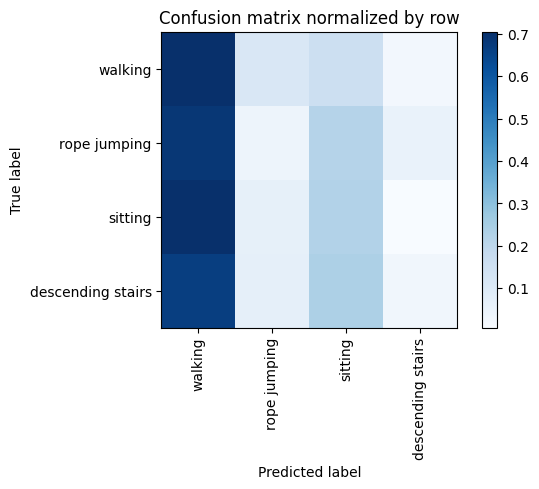

Overall accuracy: 0.376

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.425      0.705      0.530      0.419        366|	 sitting: 0.158,	rope jumping: 0.112,	
          sitting       0.358      0.225      0.276      0.316        276|	 walking: 0.703,	rope jumping: 0.065,	
descending stairs       0.250      0.032      0.056      0.181        158|	 walking: 0.665,	sitting: 0.234,	rope jumping: 0.070,	
     rope jumping       0.041      0.041      0.041      0.084         73|	 walking: 0.685,	sitting: 0.219,	descending stairs: 0.055,	

----------------------------------------------------------------------------------------------------
      avg / total       0.340      0.376      0.323        1.0        873|	      

{'total_accuracy': 0.3757159221076747, 'precision': 0.2686296448656455, 'recall': 0.25057429349437943, 'f1': 0.22594088324657843}
================ Fold-2 ================
Unseen Classes : ['playing soccer

eval: 100%|██████████| 24/24 [00:00<00:00, 53.81batch/s, loss=3.68]


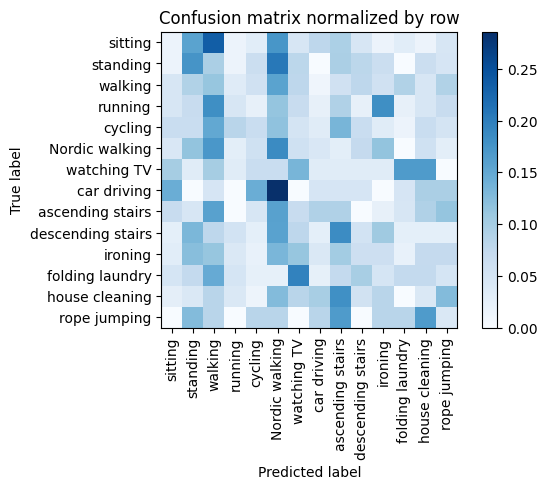

Training Epoch:  10%|█         | 1/10 [00:04<00:39,  4.44s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 24/24 [00:00<00:00, 56.14batch/s, loss=2.18]


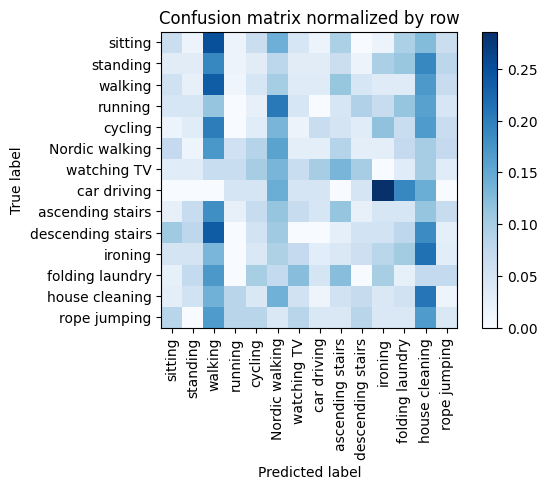

Training Epoch:  20%|██        | 2/10 [00:08<00:35,  4.38s/it]

Overall accuracy: 0.099



eval: 100%|██████████| 24/24 [00:00<00:00, 51.95batch/s, loss=1.33]


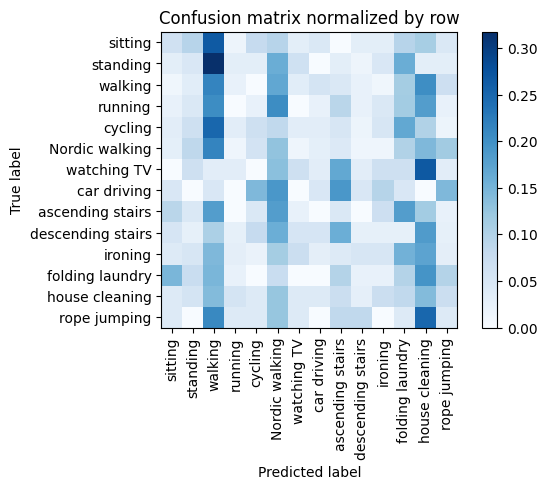

Training Epoch:  30%|███       | 3/10 [00:12<00:30,  4.30s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 24/24 [00:00<00:00, 61.70batch/s, loss=1.1]


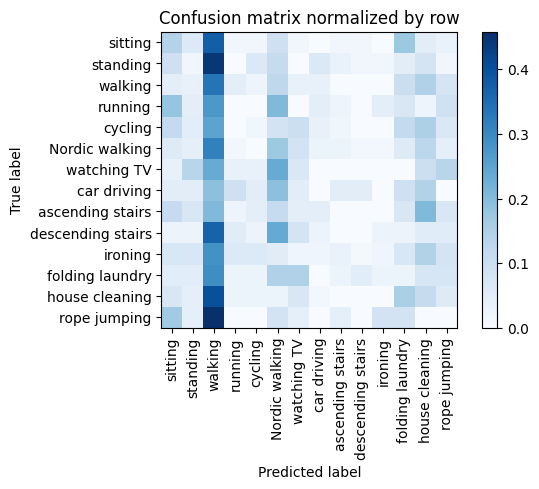

Training Epoch:  40%|████      | 4/10 [00:17<00:25,  4.27s/it]

Overall accuracy: 0.087



eval: 100%|██████████| 24/24 [00:00<00:00, 56.87batch/s, loss=0.774]


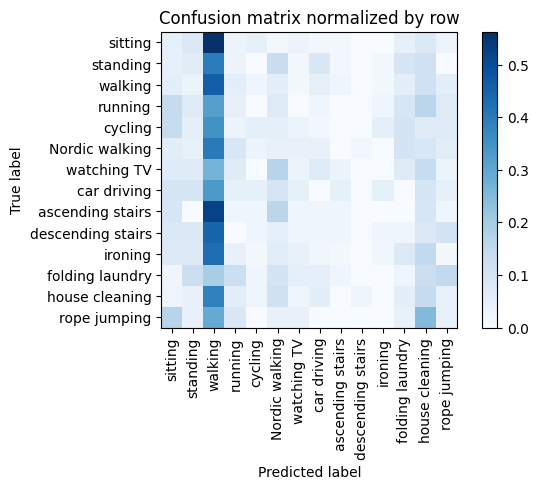

Training Epoch:  50%|█████     | 5/10 [00:21<00:21,  4.25s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 24/24 [00:00<00:00, 63.16batch/s, loss=0.722]


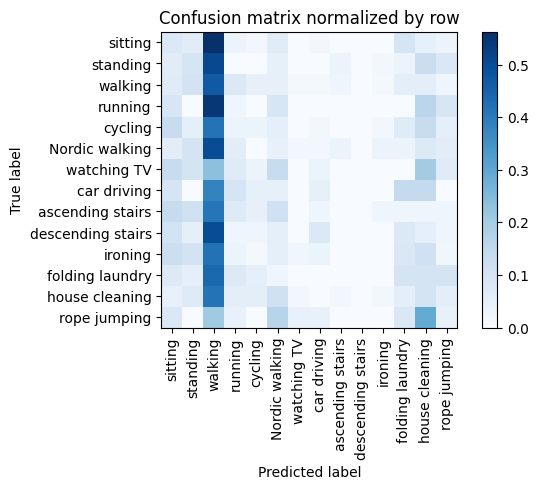

Training Epoch:  60%|██████    | 6/10 [00:25<00:16,  4.12s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 24/24 [00:00<00:00, 62.34batch/s, loss=0.622]


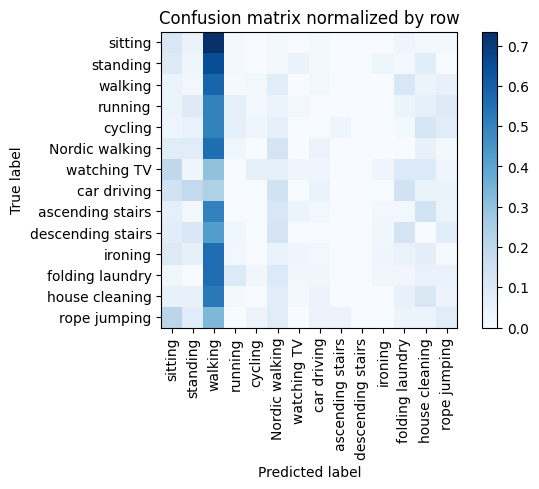

Training Epoch:  70%|███████   | 7/10 [00:28<00:11,  3.97s/it]

Overall accuracy: 0.120



eval: 100%|██████████| 24/24 [00:00<00:00, 65.04batch/s, loss=0.572]


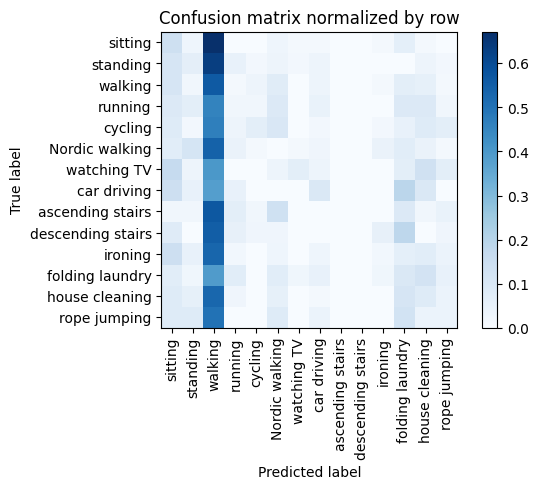

Training Epoch:  80%|████████  | 8/10 [00:32<00:07,  3.86s/it]

Overall accuracy: 0.112



eval: 100%|██████████| 24/24 [00:00<00:00, 66.85batch/s, loss=0.616]


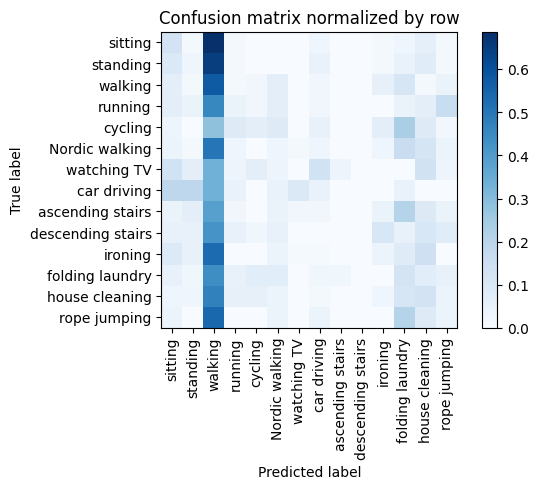

Training Epoch:  90%|█████████ | 9/10 [00:36<00:03,  3.86s/it]

Overall accuracy: 0.117



eval: 100%|██████████| 24/24 [00:00<00:00, 62.99batch/s, loss=0.495]


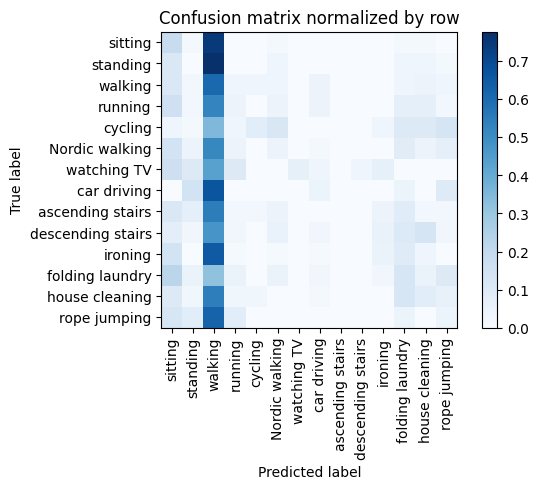

Overall accuracy: 0.127



eval: 100%|██████████| 35/35 [00:00<00:00, 73.53batch/s, loss=0.573]


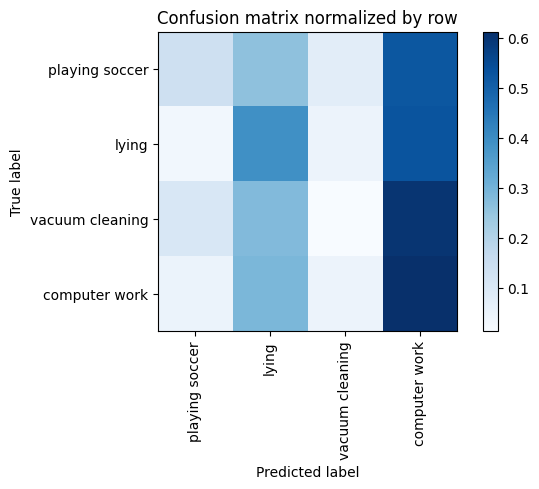

Overall accuracy: 0.375

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.445      0.612      0.515      0.423        467|	 lying: 0.289,	playing soccer: 0.051,	
          lying       0.333      0.392      0.361      0.265        293|	 computer work: 0.529,	vacuum cleaning: 0.048,	
vacuum cleaning       0.089      0.014      0.025      0.253        280|	 computer work: 0.600,	lying: 0.279,	playing soccer: 0.107,	
 playing soccer       0.125      0.138      0.131      0.059         65|	 computer work: 0.523,	lying: 0.262,	

----------------------------------------------------------------------------------------------------
    avg / total       0.306      0.375      0.327        1.0       1105|	      

{'total_accuracy': 0.3746606334841629, 'precision': 0.2480030672196302, 'recall': 0.2894146051345443, 'f1': 0.2579547821606719}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walkin

eval: 100%|██████████| 27/27 [00:00<00:00, 44.78batch/s, loss=10.7]


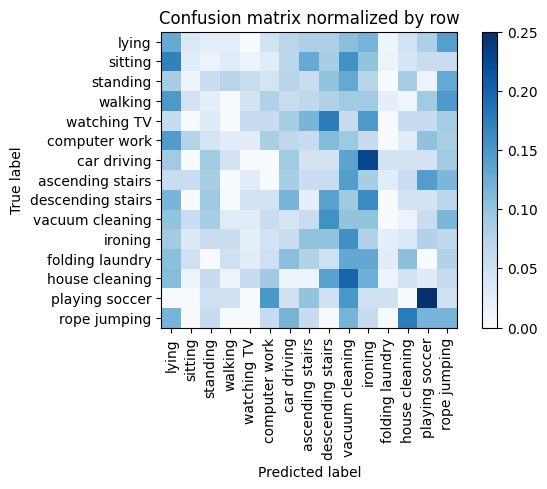

Training Epoch:  10%|█         | 1/10 [00:05<00:50,  5.60s/it]

Overall accuracy: 0.074



eval: 100%|██████████| 27/27 [00:00<00:00, 40.51batch/s, loss=5.7]


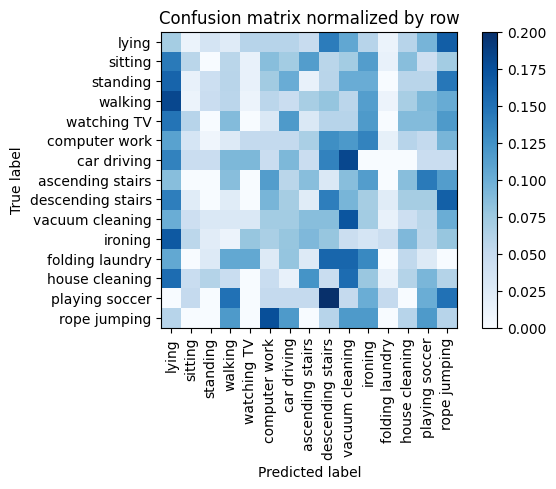

Training Epoch:  20%|██        | 2/10 [00:12<00:48,  6.10s/it]

Overall accuracy: 0.066



eval: 100%|██████████| 27/27 [00:00<00:00, 43.06batch/s, loss=3.9]


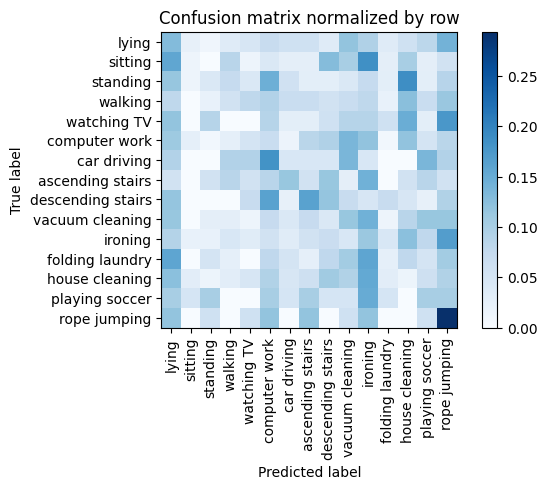

Training Epoch:  30%|███       | 3/10 [00:18<00:43,  6.15s/it]

Overall accuracy: 0.073



eval: 100%|██████████| 27/27 [00:00<00:00, 44.93batch/s, loss=2.72]


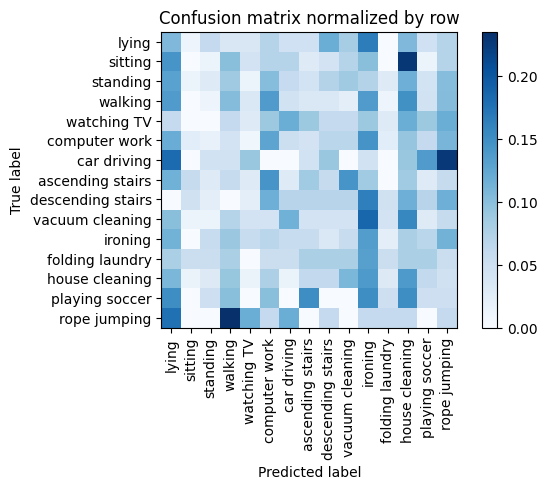

Training Epoch:  40%|████      | 4/10 [00:24<00:37,  6.23s/it]

Overall accuracy: 0.081



eval: 100%|██████████| 27/27 [00:00<00:00, 41.67batch/s, loss=1.89]


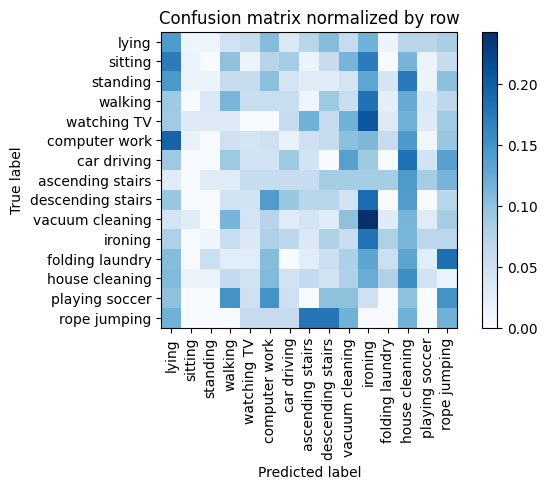

Training Epoch:  50%|█████     | 5/10 [00:31<00:31,  6.31s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 27/27 [00:00<00:00, 42.25batch/s, loss=1.69]


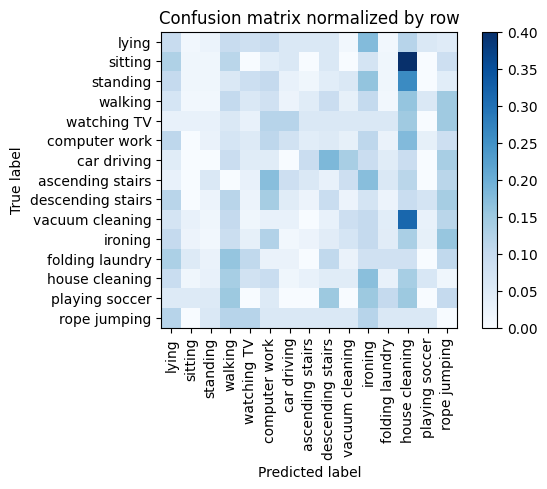

Training Epoch:  60%|██████    | 6/10 [00:37<00:25,  6.35s/it]

Overall accuracy: 0.076



eval: 100%|██████████| 27/27 [00:00<00:00, 45.88batch/s, loss=1.45]


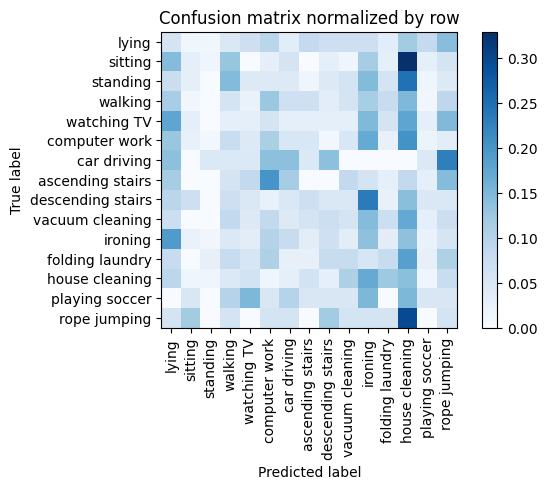

Training Epoch:  70%|███████   | 7/10 [00:43<00:19,  6.34s/it]

Overall accuracy: 0.071



eval: 100%|██████████| 27/27 [00:00<00:00, 44.48batch/s, loss=1.35]


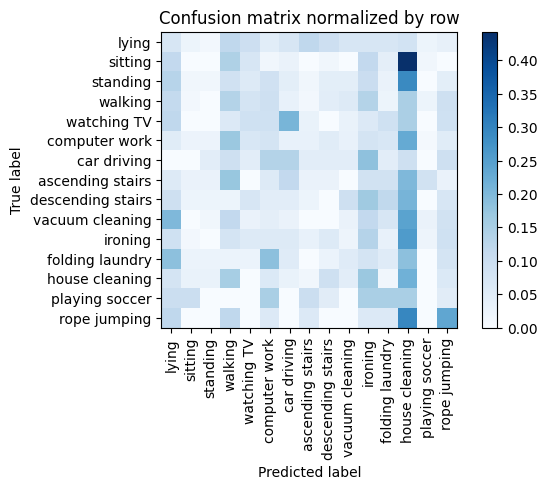

Training Epoch:  80%|████████  | 8/10 [00:49<00:12,  6.28s/it]

Overall accuracy: 0.080



eval: 100%|██████████| 27/27 [00:00<00:00, 53.36batch/s, loss=1.12]


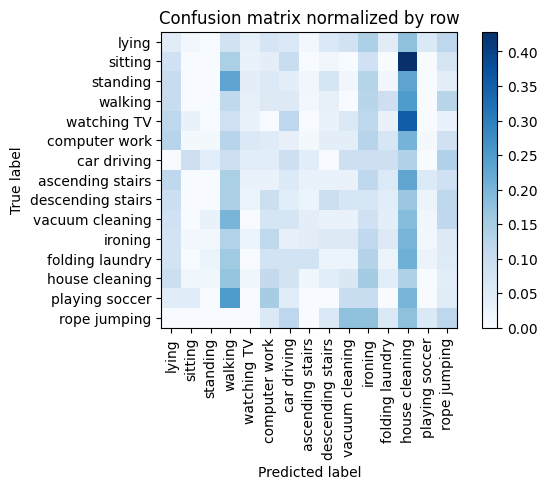

Training Epoch:  90%|█████████ | 9/10 [00:56<00:06,  6.44s/it]

Overall accuracy: 0.060



eval: 100%|██████████| 27/27 [00:00<00:00, 42.62batch/s, loss=0.971]


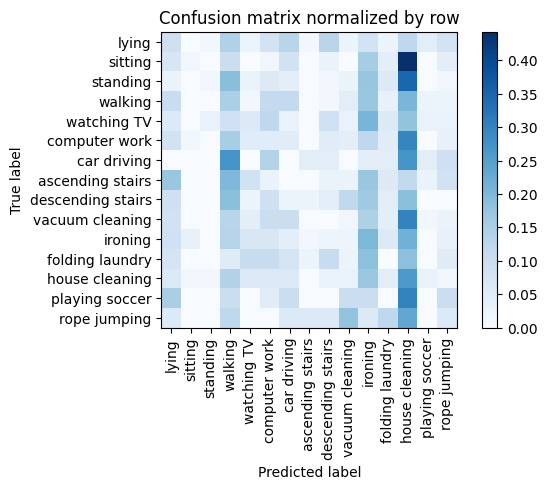

Overall accuracy: 0.081



eval: 100%|██████████| 22/22 [00:00<00:00, 47.16batch/s, loss=1.46]


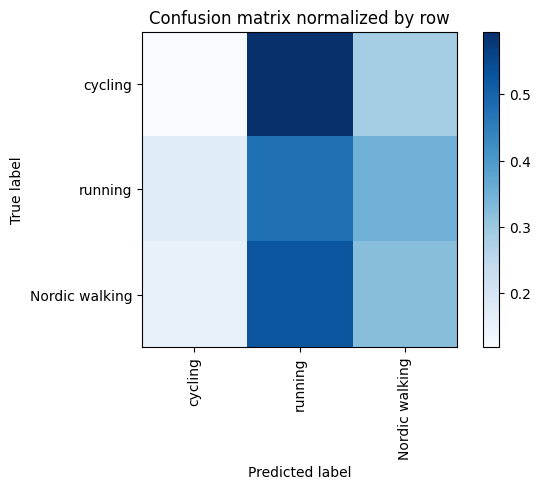

Overall accuracy: 0.283

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.435      0.322      0.370      0.426        292|	 running: 0.524,	cycling: 0.154,	
       cycling       0.290      0.119      0.169      0.356        244|	 running: 0.594,	Nordic walking: 0.287,	
       running       0.192      0.477      0.274      0.218        149|	 Nordic walking: 0.349,	cycling: 0.174,	

----------------------------------------------------------------------------------------------------
   avg / total       0.331      0.283      0.277        1.0        685|	      

{'total_accuracy': 0.2832116788321168, 'precision': 0.3058657031014755, 'recall': 0.30576011144988846, 'f1': 0.2709382218171817}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 50.45batch/s, loss=4.2]


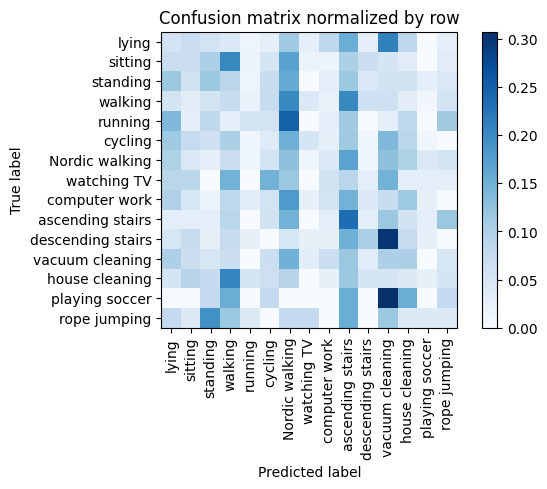

Training Epoch:  10%|█         | 1/10 [00:06<00:59,  6.57s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 28/28 [00:00<00:00, 45.83batch/s, loss=2.05]


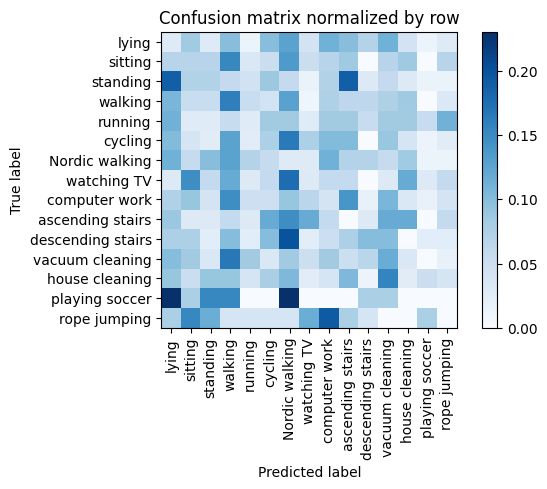

Training Epoch:  20%|██        | 2/10 [00:13<00:53,  6.70s/it]

Overall accuracy: 0.061



eval: 100%|██████████| 28/28 [00:00<00:00, 46.43batch/s, loss=1.49]


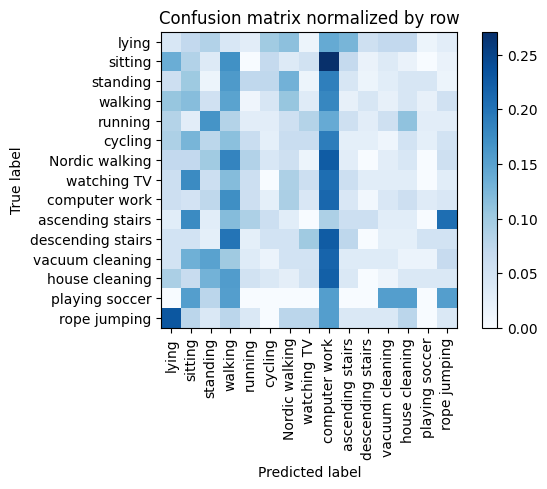

Training Epoch:  30%|███       | 3/10 [00:19<00:46,  6.62s/it]

Overall accuracy: 0.075



eval: 100%|██████████| 28/28 [00:00<00:00, 45.68batch/s, loss=1.19]


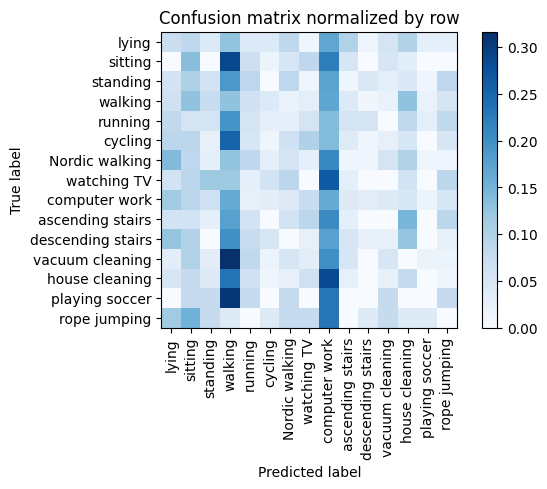

Training Epoch:  40%|████      | 4/10 [00:26<00:39,  6.63s/it]

Overall accuracy: 0.076



eval: 100%|██████████| 28/28 [00:00<00:00, 39.22batch/s, loss=0.766]


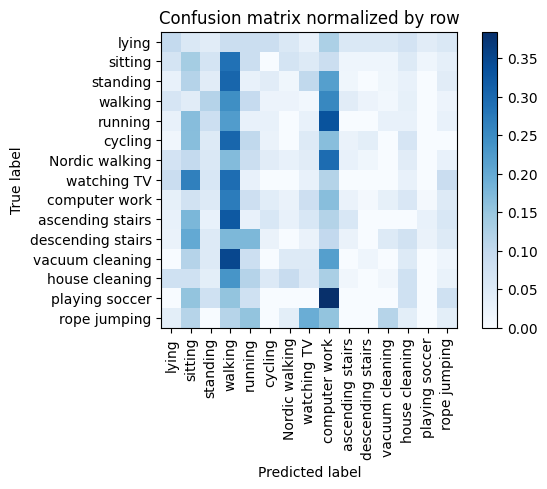

Training Epoch:  50%|█████     | 5/10 [00:33<00:33,  6.68s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 28/28 [00:00<00:00, 45.45batch/s, loss=0.834]


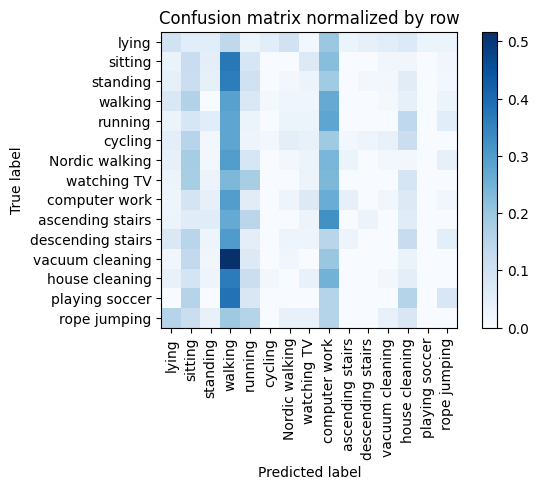

Training Epoch:  60%|██████    | 6/10 [00:40<00:26,  6.73s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 28/28 [00:00<00:00, 44.37batch/s, loss=0.711]


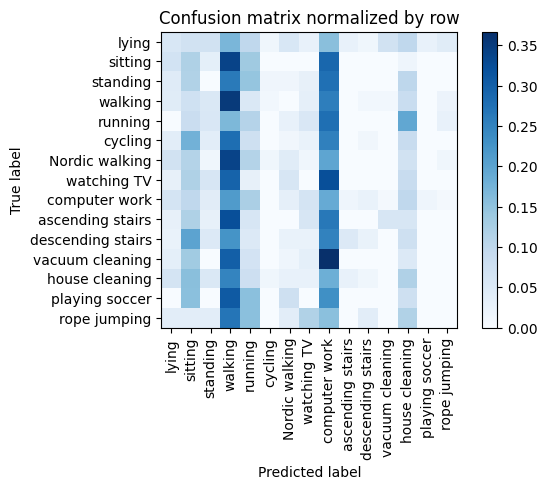

Training Epoch:  70%|███████   | 7/10 [00:46<00:19,  6.66s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 28/28 [00:00<00:00, 43.13batch/s, loss=0.638]


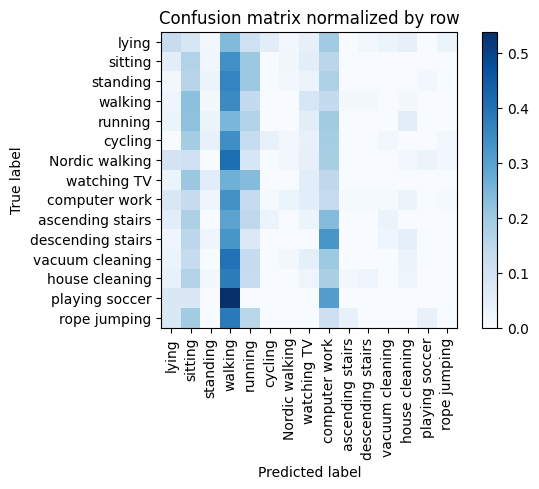

Training Epoch:  80%|████████  | 8/10 [00:54<00:13,  6.95s/it]

Overall accuracy: 0.095



eval: 100%|██████████| 28/28 [00:00<00:00, 44.73batch/s, loss=0.582]


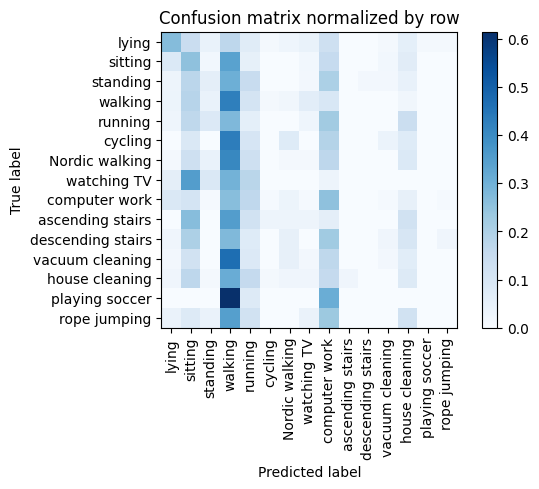

Training Epoch:  90%|█████████ | 9/10 [01:00<00:06,  6.83s/it]

Overall accuracy: 0.134



eval: 100%|██████████| 28/28 [00:00<00:00, 43.75batch/s, loss=0.554]


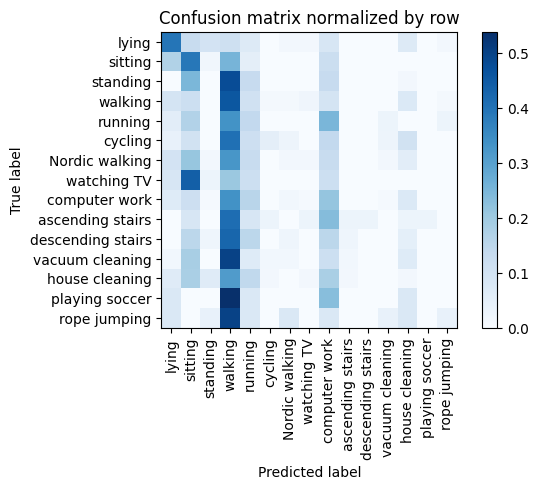

Overall accuracy: 0.150



eval: 100%|██████████| 19/19 [00:00<00:00, 44.60batch/s, loss=0.605]


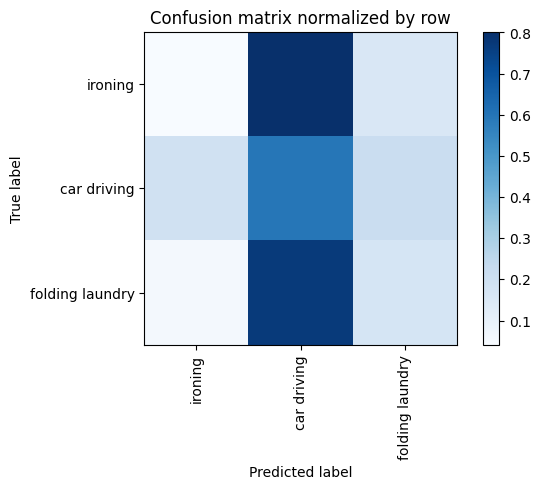

Overall accuracy: 0.149

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.385      0.041      0.075      0.606        363|	 car driving: 0.802,	folding laundry: 0.157,	
folding laundry       0.267      0.172      0.209      0.262        157|	 car driving: 0.771,	ironing: 0.057,	
    car driving       0.102      0.595      0.175      0.132         79|	 folding laundry: 0.215,	ironing: 0.190,	

----------------------------------------------------------------------------------------------------
    avg / total       0.317      0.149      0.123        1.0        599|	      

{'total_accuracy': 0.14858096828046743, 'precision': 0.2514462104832907, 'recall': 0.2694111817344466, 'f1': 0.15288346028137173}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.287347
precision         0.263585
recall            0.268190
f1                0.213227
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model9(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], 
                num_layers=config['num_layers'], ft_size=feat_size, attr_size=attr_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=True)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=True, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    